# ASSIGNMENT 7:

- Luis Felipe Acosta Zavaleta
- Alejandro Mosquera Ospina
- Raúl Emerson Amao Guerra
- Manuel Antonio Gil Soto Pisco
- Ruth Marina Chávez Pacheco

In [24]:
# We import the necessary libraries

#!pip install pandas
#!pip install geopandas
#!pip install mapclassify

import pandas as pd
import os
import urllib.request, json, csv
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import numpy as np

## 1. Import the data located at this link. It has information on people infected with dengue at the district level for 2015 to 2021.


In [9]:
#We import the csv file

url = 'https://raw.githubusercontent.com/alexanderquispe/Diplomado_PUCP/main/_data/data_dengue_peru.csv'

df = pd.read_csv(url, low_memory = False)
print(df.head())



    Año  Semana Eventos o daños Departamento   Distrito       Provincia  \
0  2020      43          Dengue        CUSCO  MEGANTONI   LA CONVENCION   
1  2021      41          Dengue     MOQUEGUA   MOQUEGUA  MARISCAL NIETO   
2  2021      42          Dengue     MOQUEGUA   MOQUEGUA  MARISCAL NIETO   
3  2020       1          Dengue        CUSCO  MEGANTONI   LA CONVENCION   
4  2020      53          Dengue        CUSCO  MEGANTONI   LA CONVENCION   

   Ubigeo Casos  
0   80914     2  
1  180101   NaN  
2  180101   NaN  
3   80914     0  
4   80914     2  


## 2. Generate ubigeo for Departments and Provinces taking the first two and four numbers.

In [13]:
# We generate the requested columns

df['Ubigeo_Departamento'] = df['Ubigeo'].astype(str).str[:-4]  # This extracts all the numbers except the last four digits of the ubigeo column
df['Ubigeo_Provincia'] = df['Ubigeo'].astype(str).str[-4:]     #This extracts the last four digits of the ubigeo column

print(df[['Ubigeo', 'Ubigeo_Departamento', 'Ubigeo_Provincia']].head())

   Ubigeo Ubigeo_Departamento Ubigeo_Provincia
0   80914                   8             0914
1  180101                  18             0101
2  180101                  18             0101
3   80914                   8             0914
4   80914                   8             0914


## 3. Use geopandas to plot the number of cases in 2021 by the district using a continuous legend. Do not forget to indicate the color of NA values. Use this shapefile.

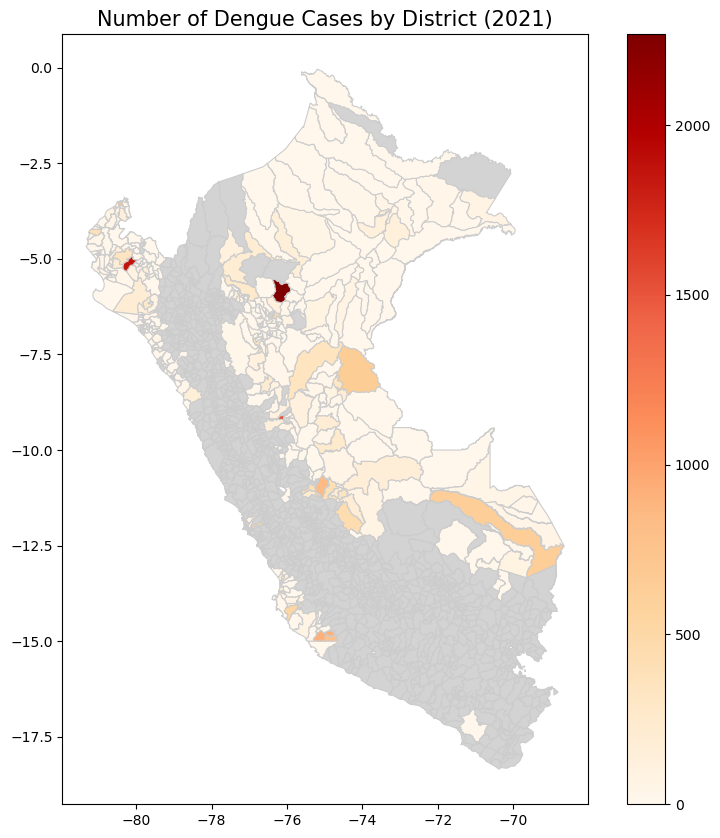

In [16]:
# Raw URL of the shapefile on GitHub
shp = r'https://github.com/alexanderquispe/Diplomado_PUCP/raw/main/_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp'

# Read the shapefile using the raw URL
dist_shp = gpd.read_file(shp)

# Load the dengue data
url = 'https://raw.githubusercontent.com/alexanderquispe/Diplomado_PUCP/main/_data/data_dengue_peru.csv'
df_dengue = pd.read_csv(url, low_memory = False)

df_2021 = df_dengue[df_dengue['Año'] == 2021] #Filter for year 2021
df_2021.loc[:, 'Casos'] = pd.to_numeric(df_2021['Casos'], errors='coerce') #Convert the 'Casos' column to numeric, forcing non-numeric values to NaN
df_2021_grouped = df_2021.groupby('Ubigeo')['Casos'].sum().reset_index() #Group by Ubigeo of the district and sum the Casos column for each group

# Convert 'Casos' column to integers
df_2021_grouped['Casos'] = df_2021_grouped['Casos'].astype(int)

df_2021_grouped['Ubigeo'] = df_2021_grouped['Ubigeo'].astype(str)
dist_shp['UBIGEO'] = dist_shp['UBIGEO'].astype(str) #Ensure the 'Ubigeo' column is a string in both datasets

dist_shp1 = dist_shp.merge(df_2021_grouped, left_on='UBIGEO', right_on='Ubigeo', how='left') # Merge Dengue cases with the shapefile

#Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
dist_shp1.plot(column='Casos', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
               missing_kwds={"color": "lightgrey", "label": "NaN"})

# Set plot title and labels
ax.set_title('Number of Dengue Cases by District (2021)', fontsize=15)

# Show the plot
plt.show()

## 4. Use geopandas to plot the number of cases in 2021 by the province using a continuous legend.

/var/folders/1k/pjnsy8n53cdb4bmkqdvylj8c0000gn/T/ipykernel_34781/3806454596.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prov_shp['Casos'] = prov_shp['Casos'].fillna(0).astype(int)


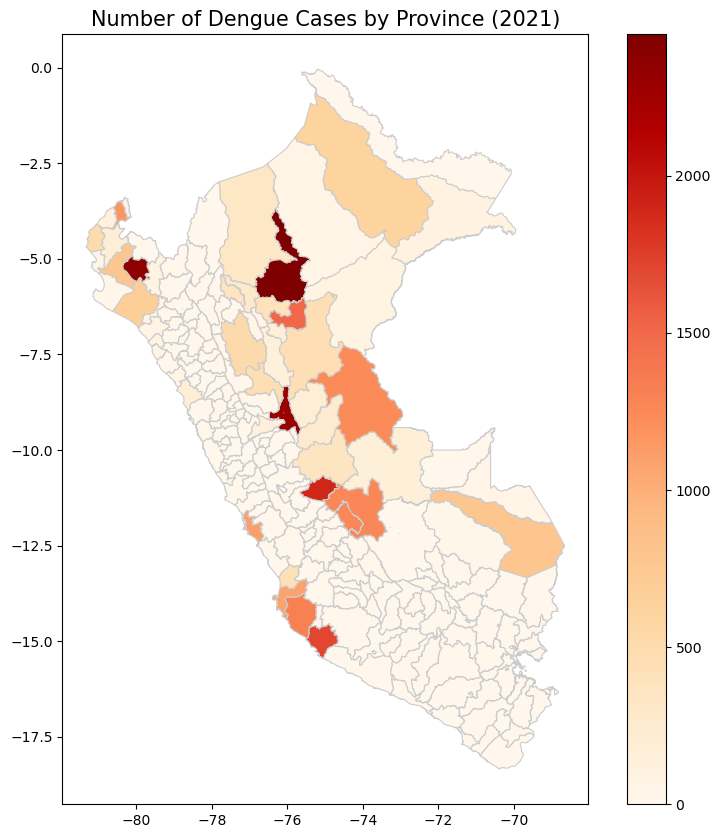

In [18]:
# URL of the shapefile
shp_url = 'https://github.com/alexanderquispe/Diplomado_PUCP/raw/main/_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp'

# Load the shapefile 
df = gpd.read_file(shp_url)

# Load the dengue data
url = 'https://raw.githubusercontent.com/alexanderquispe/Diplomado_PUCP/main/_data/data_dengue_peru.csv' 
df_dengue = pd.read_csv(url, low_memory=False)

# Filter dengue data for the year 2021
df_2021 = df_dengue[df_dengue['Año'] == 2021].copy()  # Create a copy to avoid SettingWithCopyWarning

# Convert 'Casos' column to numeric, handling errors
df_2021.loc[:, 'Casos'] = pd.to_numeric(df_2021['Casos'], errors='coerce')

# Aggregate dengue cases by province
df_2021_grouped = df_2021.groupby('Ubigeo')['Casos'].sum().reset_index()
df_2021_grouped['Ubigeo'] = df_2021_grouped['Ubigeo'].astype(str)  # Ensure 'Ubigeo' is a string

# Prepare shapefile for merging
df['UBIGEO_PROV'] = df['UBIGEO'].astype(str).str[:4]  # Extract the first 4 digits for province-level aggregation

# Dissolve the shapefile by province level
prov_shp = df.dissolve(by='UBIGEO_PROV')

# Aggregate cases by province
cases_by_province = df_2021_grouped.groupby(df_2021_grouped['Ubigeo'].str[:4])['Casos'].sum().reset_index()
cases_by_province.columns = ['UBIGEO_PROV', 'Casos']

# Merge shapefile with case data
prov_shp = prov_shp.merge(cases_by_province, left_on='UBIGEO_PROV', right_on='UBIGEO_PROV', how='left')

# Convert 'Casos' to integer, handling NaN values
prov_shp['Casos'] = prov_shp['Casos'].fillna(0).astype(int)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
prov_shp.plot(column='Casos', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
              missing_kwds={"color": "lightgrey", "label": "No Data"})
ax.set_title('Number of Dengue Cases by Province (2021)', fontsize=15)
plt.show()


## 5.  Use geopandas to plot the number of cases by the department for all the years using subplots. Every subplot for each year. Do not forget to indicate the color of NA values. Use this shapefile. For this task, you will have to aggregate shapefiles at the department level.

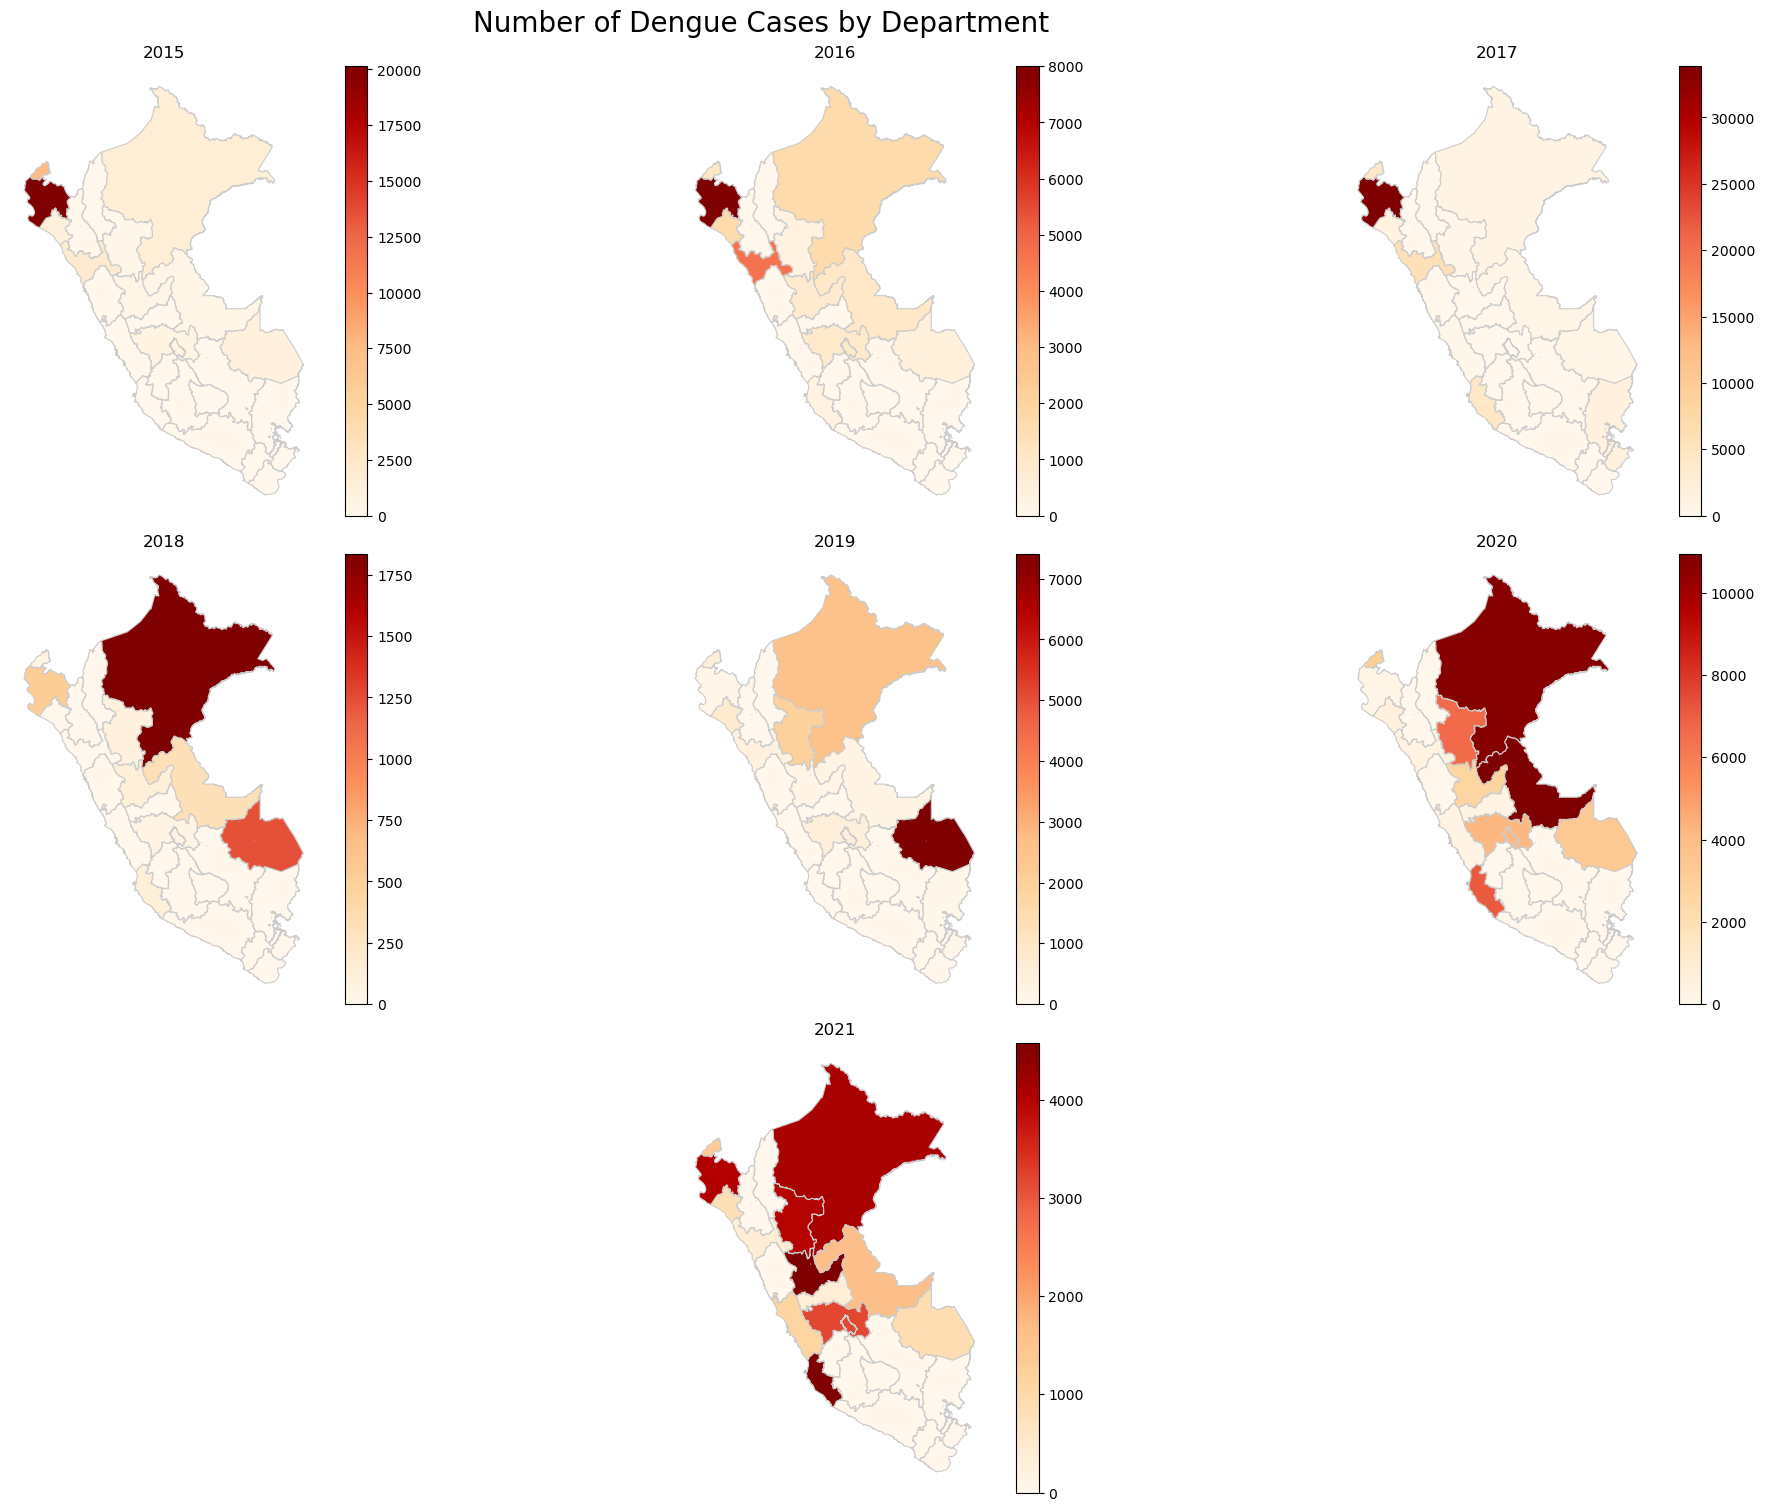

In [20]:
# URL of the shapefile
shp_url = 'https://github.com/alexanderquispe/Diplomado_PUCP/raw/main/_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp'

# Load the shapefile
df = gpd.read_file(shp_url)

# URL of the dengue data
dengue_url = 'https://raw.githubusercontent.com/alexanderquispe/Diplomado_PUCP/main/_data/data_dengue_peru.csv'
df_dengue = pd.read_csv(dengue_url, low_memory=False)

# Convert 'Casos' column to numeric
df_dengue['Casos'] = pd.to_numeric(df_dengue['Casos'], errors='coerce')

# Ensure 'Ubigeo' is a string before extracting department code
df_dengue['Ubigeo'] = df_dengue['Ubigeo'].astype(str)
df_dengue['DEPARTAMENTO'] = df_dengue['Ubigeo'].str[:2]  # Extract the first 2 digits for department level

# Aggregate dengue cases by department and year
cases_by_dept = df_dengue.groupby(['Año', 'DEPARTAMENTO'])['Casos'].sum().reset_index()

# Extract department code from shapefile for merging
df['DEPARTAMENTO'] = df['UBIGEO'].astype(str).str[:2]  # Extract the first 2 digits for department level

# Dissolve the shapefile by department level
dept_shp = df.dissolve(by='DEPARTAMENTO')

# Get unique years from the dengue data
years = sorted(df_dengue['Año'].unique())

# Set up the figure and axes for subplots (3 rows, 3 columns)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), constrained_layout=True)

# Set the main title
fig.suptitle('Number of Dengue Cases by Department', fontsize=20)

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Plot the first 6 years (2 rows, 3 columns)
for i, year in enumerate(years[:6]):
    # Filter dengue cases for the specific year
    cases_for_year = cases_by_dept[cases_by_dept['Año'] == year]
    
    # Merge the aggregated cases with the shapefile
    merged_shp = dept_shp.merge(cases_for_year, left_on='DEPARTAMENTO', right_on='DEPARTAMENTO', how='left')
    
    # Convert 'Casos' to integer, handling NaN values
    merged_shp['Casos'] = merged_shp['Casos'].fillna(0).astype(int)
    
    # Plot on the current axis
    ax = axes[i]
    merged_shp.plot(column='Casos', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                    missing_kwds={"color": "lightgrey", "label": "No Data"})
    ax.set_title(f'{year}', fontsize=12)  # Subtitle with only the year
    ax.set_axis_off()

# Plot the 7th year in the third row, second column (index 7 in a 0-based index)
cases_for_year = cases_by_dept[cases_by_dept['Año'] == years[6]]
merged_shp = dept_shp.merge(cases_for_year, left_on='DEPARTAMENTO', right_on='DEPARTAMENTO', how='left')
merged_shp['Casos'] = merged_shp['Casos'].fillna(0).astype(int)
ax = axes[7]  # The second column in the third row is index 7
merged_shp.plot(column='Casos', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                missing_kwds={"color": "lightgrey", "label": "No Data"})
ax.set_title(f'{years[6]}', fontsize=12)  # Subtitle with only the year
ax.set_axis_off()

# Hide the unused subplots (first and third columns in the third row)
axes[6].set_visible(False)
axes[8].set_visible(False)

# Show the plot
plt.show()

## 6. Use geopandas to plot the number of cases by the department for all 2021 quarters using subplots. Every subplot for each quarter. Use a categorical legend with 5 bins. Do not forget to indicate the color of NA values. Use this shapefile. For this task, you will have to aggregate shapefiles at the department level. Hint: Use Semana variable to group by quarters.

/var/folders/1k/pjnsy8n53cdb4bmkqdvylj8c0000gn/T/ipykernel_34781/1465490421.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cases_by_dept_quarter = df_dengue.groupby(['Quarter', 'DEPARTAMENTO'])['Casos'].sum().reset_index()
/var/folders/1k/pjnsy8n53cdb4bmkqdvylj8c0000gn/T/ipykernel_34781/1465490421.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cases_by_dept_quarter_full = all_combinations.merge(cases_by_dept_quarter, on=['Quarter', 'DEPARTAMENTO'], how='left').fillna(0)


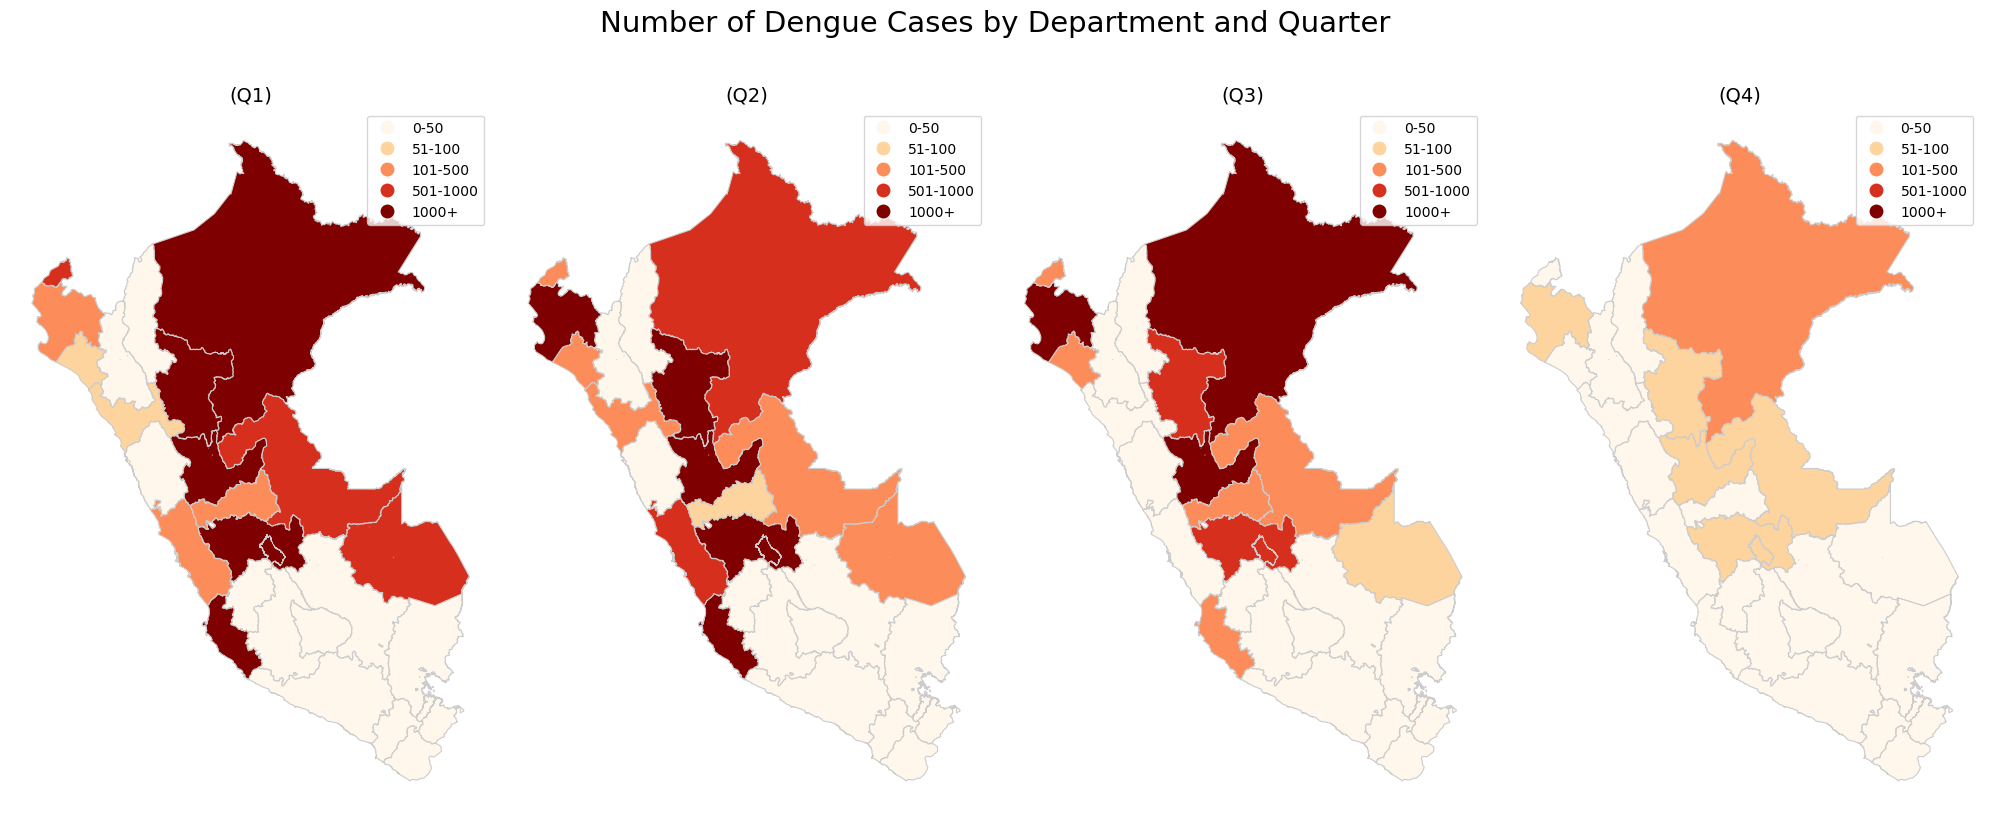

In [26]:
# URL of the shapefile
shp_url = 'https://github.com/alexanderquispe/Diplomado_PUCP/raw/main/_data/LIMITE_DISTRITAL_2020_INEI/INEI_LIMITE_DISTRITAL.shp'

# Load the shapefile
df = gpd.read_file(shp_url)

# URL of the dengue data
dengue_url = 'https://raw.githubusercontent.com/alexanderquispe/Diplomado_PUCP/main/_data/data_dengue_peru.csv'
df_dengue = pd.read_csv(dengue_url, low_memory=False)

# Convert 'Casos' column to numeric
df_dengue['Casos'] = pd.to_numeric(df_dengue['Casos'], errors='coerce')

# Filter data for the year 2021
df_dengue = df_dengue[df_dengue['Año'] == 2021]

# Ensure 'Semana' is a string and extract quarter information
df_dengue['Semana'] = df_dengue['Semana'].astype(str).str.zfill(2)  # Ensure 'Semana' is 2 digits
df_dengue['Semana'] = pd.to_numeric(df_dengue['Semana'], errors='coerce')  # Convert to numeric

# Limit weeks to 52 (to avoid incorrect 5th quarter)
df_dengue = df_dengue[df_dengue['Semana'] <= 52]

# Calculate quarters (1-13 weeks in Q1, 14-26 in Q2, 27-39 in Q3, 40-52 in Q4)
df_dengue['Quarter'] = pd.cut(df_dengue['Semana'], bins=[0, 13, 26, 39, 52], labels=[1, 2, 3, 4], right=True)

# Extract department code from 'Ubigeo'
df_dengue['DEPARTAMENTO'] = df_dengue['Ubigeo'].astype(str).str[:2]  # Extract the first 2 digits for department level

# Aggregate dengue cases by department and quarter
cases_by_dept_quarter = df_dengue.groupby(['Quarter', 'DEPARTAMENTO'])['Casos'].sum().reset_index()

# Extract department code from shapefile for merging
df['DEPARTAMENTO'] = df['UBIGEO'].astype(str).str[:2]  # Extract the first 2 digits for department level

# Dissolve the shapefile by department level
dept_shp = df.dissolve(by='DEPARTAMENTO').reset_index()

# Get unique quarters
quarters = sorted(df_dengue['Quarter'].unique())

# Create all possible department-quarter combinations to ensure no gaps
all_depts = dept_shp['DEPARTAMENTO'].unique()
all_combinations = pd.MultiIndex.from_product([quarters, all_depts], names=['Quarter', 'DEPARTAMENTO']).to_frame(index=False)

# Merge the dengue data with all combinations, filling missing cases with 0
cases_by_dept_quarter_full = all_combinations.merge(cases_by_dept_quarter, on=['Quarter', 'DEPARTAMENTO'], how='left').fillna(0)

# Merge the full dengue cases data with the geometries
merged_shp = dept_shp.merge(cases_by_dept_quarter_full, on='DEPARTAMENTO', how='left')

# Define bins and labels for categorical plot
bins = [0, 50, 100, 500, 1000, np.inf]
labels = ['0-50', '51-100', '101-500', '501-1000', '1000+']

# Create a new column 'Category' with categorical data
merged_shp['Category'] = pd.cut(merged_shp['Casos'], bins=bins, labels=labels, include_lowest=True)

# Plotting
fig, axes = plt.subplots(1, len(quarters), figsize=(20, 10), sharex=True, sharey=True)

for i, quarter in enumerate(quarters):
    ax = axes[i]
    
    # Filter data for the current quarter
    current_quarter_data = merged_shp[merged_shp['Quarter'] == quarter]

    # Plot with categorical data
    current_quarter_data.plot(column='Category', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                              missing_kwds={"color": "lightgrey", "label": "No Data"})  # Set missing values to light grey
    
    ax.set_title(f'(Q{quarter})', fontsize=14)
    ax.set_axis_off()

# Add a main title for the entire figure
fig.suptitle('Number of Dengue Cases by Department and Quarter', fontsize=21)

plt.tight_layout(rect=[0, 0, 1, 1.1])  # Adjust layout to make room for suptitle
plt.show()